# Bijective Maps from Simplicial Foliations

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


In [67]:
x, y = np.meshgrid(np.arange(3)+1,np.arange(4))
x = x.flatten()
y = y.flatten()

tilt60 = np.array([[1,-0.5],[0,np.sqrt(0.75)]])
x0,y0 = tilt60 @ np.vstack([x,y])



In [68]:

# Copy the existing points
x_new = np.copy(x0)
y_new = np.copy(y0)

for i in [120,240]:
    rot_angle = i  # Rotation angle in degrees
    rot_rad = np.radians(rot_angle)  # Convert to radians
    rot_matrix = np.array([[np.cos(rot_rad), -np.sin(rot_rad)],
                        [np.sin(rot_rad), np.cos(rot_rad)]])
    rotated_points = np.dot(rot_matrix, np.vstack([x_new, y_new]))

    # Add the rotated points to the existing arrays
    x0 = np.concatenate([x0, rotated_points[0]])
    y0 = np.concatenate([y0, rotated_points[1]])

x0 = np.concatenate([x0, [0]])
y0 = np.concatenate([y0, [0]])

triang = mtri.Triangulation(x0, y0)

x0.shape, y0.shape

((37,), (37,))

In [69]:
tri = triang.triangles
trix = triang.x
triy = triang.y

In [70]:
np.random.seed(0)

add_noise = lambda x: x + np.random.randn(len(x)) * 0.05

triang.x = add_noise(triang.x)
triang.y = add_noise(triang.y)

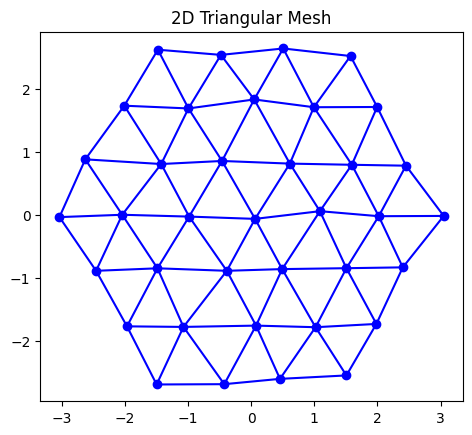

In [71]:
def plotTriangularMesh(triang):

    # 三角メッシュをプロット
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.triplot(triang, 'bo-')
    plt.title('2D Triangular Mesh')

plotTriangularMesh(triang)

In [72]:
tri.shape

(54, 3)

In [73]:
outer_edges = []

for edge in triang.edges:
    count = 0
    for triangle in triang.triangles:
        if edge[0] in triangle and edge[1] in triangle:
            count += 1
    if count == 1:
        outer_edges.append(edge)

outer_edges = np.array(outer_edges)
outer_edges.shape


(18, 2)

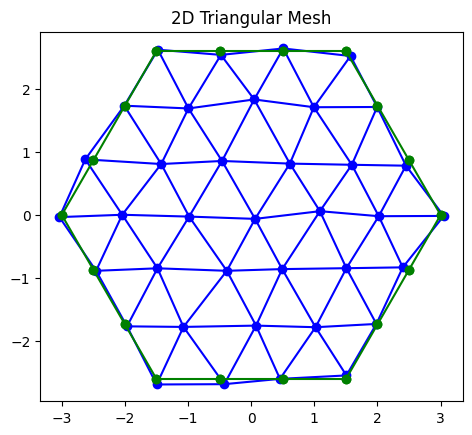

In [74]:
plotTriangularMesh(triang)

for i in range(outer_edges.shape[0]):
    x_coords = trix[outer_edges[i, :]]
    y_coords = triy[outer_edges[i, :]]
    plt.plot(x_coords, y_coords, 'go-')

plt.show()


## ラプラシアンの計算

与えられた三角形分割のラプラシアン行列を計算します。

パラメータ
triang (三角形分割)： ノード座標と三角形インデックスを含む三角形分割オブジェクト。

戻り値
laplacian (numpy.ndarray)： ラプラシアン行列。

ラプラシアン行列は、三角形分割された曲面上の離散ラプラス演算子を表す正方行列である。
メッシュ処理、画像処理、コンピュータグラフィックスなど様々なアプリケーションで使用される。

ラプラシアン行列は、三角形分割の各三角形に対して繰り返し処理を行うことで計算される。
各三角形について、辺の長さとコタンジェント値が計算されます。
ラプラシアン行列はこれらの値に基づいて更新されます。

ラプラシアン行列は次のように定義されます：

$$
L_{ij} = \begin{cases}
\sum_{k \in N(i)} \cot(\alpha_{ik}) + \cot(\beta_{ik}), & \text{if } i = j \\
-\cot(\alpha_{ij}), & \text{if } i \neq j \text{ and } (i, j) \text{ is an edge} \\
0, & \text{otherwise}
\end{cases}
$$

ここで、$N(i)$ は頂点 $i$ の隣人の集合、$\alpha_{ik}$ は辺 $(i, k)$ と反対側の角度である、
また、$\beta_{ik}$は辺$(i, k)$に隣接する三角形の辺$(i, k)$に対向する角度である。

注意: この関数は三角形分割が有効なドロネー三角形分割であることを仮定している。

Example usage:

```py
>>> triang = Triangulation(...)
>>> laplacian = calculate_laplacian(triang)
```

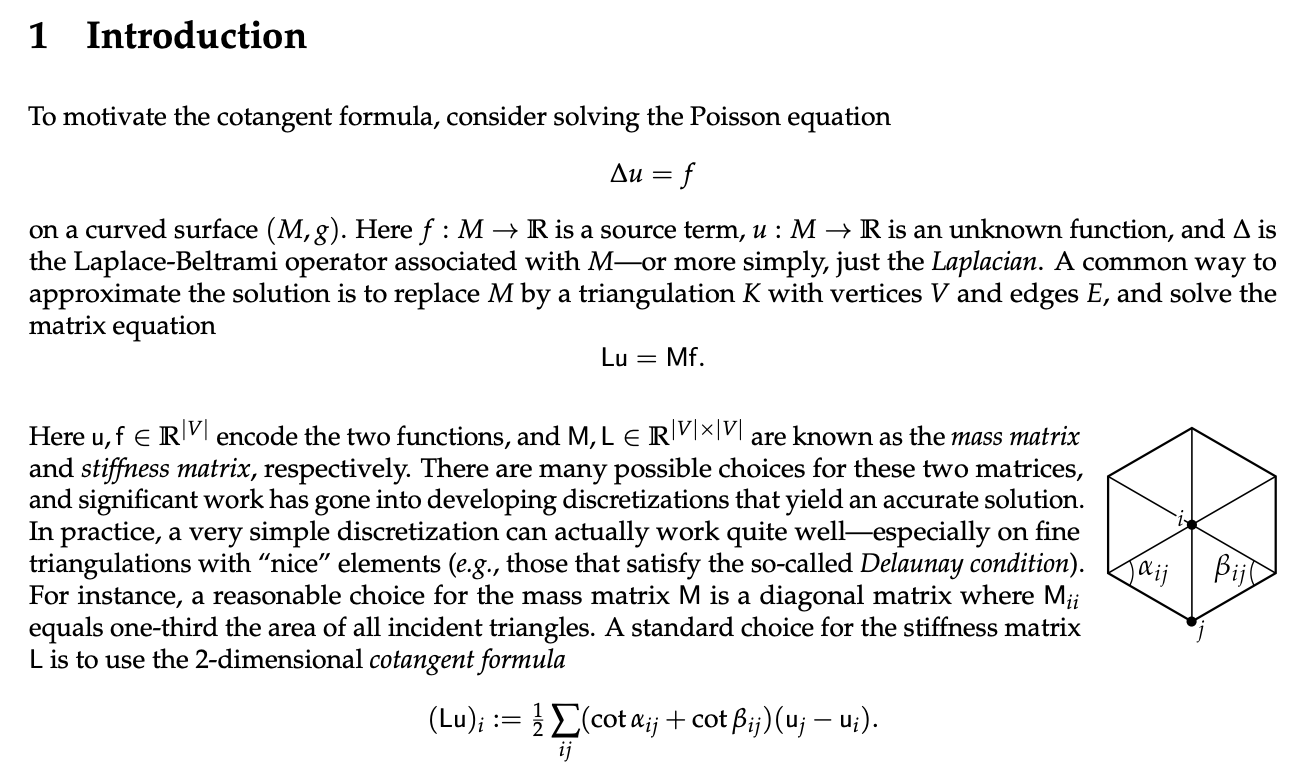

In [75]:
def mycot(a, b, c):
    cos_C = (a*a + b*b - c*c) / (2*a*b)
    cos_C2 = cos_C*cos_C
    cot_C = np.sqrt(cos_C2 / (1 - cos_C2))
    return cot_C


In [76]:
def test_cotangent():
    # Known sides of a triangle
    a = 5
    b = 4
    c = 3

    # Calculate cotangent
    cot_a = mycot(a, b, c)

    # Known cotangent of angle A
    expected_cot_a = 4 / 3

    # Check if the calculated cotangent is close to the expected value
    assert np.isclose(cot_a, expected_cot_a), f"Expected {expected_cot_a}, but got {cot_a}"

test_cotangent()

In [77]:
def calculate_laplacian(tri, trix, triy):
    # Get the node coordinates
    x = trix
    y = triy

    # Initialize the Laplacian matrix
    laplacian = np.zeros([len(x), len(x)])

    # Iterate over each triangle
    for triangle in tri:
        # Get the indices of the triangle vertices
        i, j, k = triangle

        # Calculate the edge lengths
        a = np.sqrt((x[j] - x[k])**2 + (y[j] - y[k])**2)
        b = np.sqrt((x[k] - x[i])**2 + (y[k] - y[i])**2)
        c = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)

        # Calculate the cotangent values
        cot_a = mycot(b, c, a)
        cot_b = mycot(c, a, b)
        cot_c = mycot(a, b, c)

        # Update the Laplacian matrix
        laplacian[i, i] += cot_b + cot_c
        laplacian[j, j] += cot_c + cot_a
        laplacian[k, k] += cot_a + cot_b
        laplacian[i, j] -= cot_c
        laplacian[i, k] -= cot_b
        laplacian[j, i] -= cot_c
        laplacian[j, k] -= cot_a
        laplacian[k, i] -= cot_b
        laplacian[k, j] -= cot_a

    return laplacian

laplacian_matrix = calculate_laplacian(tri, trix, triy)
print(laplacian_matrix.shape)


(37, 37)


In [78]:
def calculate_harmonic_field(tri, trix, triy):
    # Calculate the Laplacian matrix
    laplacian_matrix = calculate_laplacian(tri, trix, triy)

    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

    # Sort the eigenvalues
    eigensort = eigenvalues.argsort()

    # Get the harmonic field
    harmonic_field = eigenvectors.T[eigensort[1]]
    harmonic_values = eigenvalues[eigensort[1]]

    return harmonic_field, harmonic_values

harmonic_field, harmonic_values = calculate_harmonic_field(tri, trix, triy)
harmonic_field.shape

(37,)

In [79]:
(laplacian_matrix @ harmonic_field - harmonic_values * harmonic_field)[:8]

array([-7.59808882e-16,  6.92154667e-16, -8.27463098e-16,  1.06858966e-15,
       -1.94289029e-16,  2.70616862e-16,  8.04911693e-16, -6.66133815e-16])

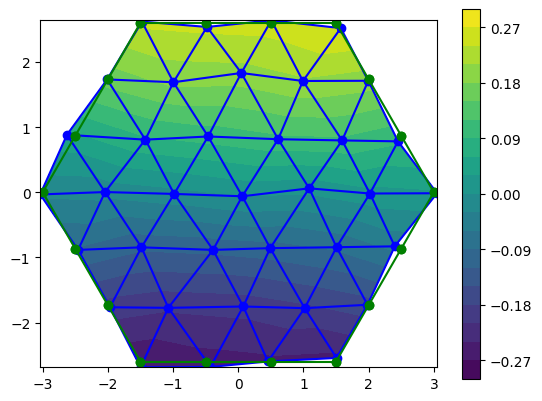

In [81]:
# Overlay the harmonic_field as contour
plt.tricontourf(triang, harmonic_field, levels=20)

# Plot the triangular mesh
plt.triplot(triang, 'bo-')

# Set the aspect ratio to equal and show the plot
plt.gca().set_aspect('equal')
plt.colorbar()

for i in range(outer_edges.shape[0]):
    x_coords = trix[outer_edges[i, :]]
    y_coords = triy[outer_edges[i, :]]
    plt.plot(x_coords, y_coords, 'go-')

plt.show()


## ラプラシアンの勾配を求める

In [82]:
def calculate_triangle_gradients(tri, trix, triy, f):

    gradients = []
    for triangle in tri:

        iA = triangle[0]
        iB = triangle[1]
        iC = triangle[2]

        A = np.array([trix[iA], triy[iA]])
        B = np.array([trix[iB], triy[iB]])
        C = np.array([trix[iC], triy[iC]])
        
        # ベクトルの定義
        AB = B - A
        AC = C - A

        fAB = f[iB] - f[iA]
        fAC = f[iC] - f[iA]

        # 勾配の計算
        grad_f = np.linalg.solve(np.array([AB, AC]), np.array([fAB, fAC]))
        gradients.append(grad_f)

    return np.array(gradients)

gradients = calculate_triangle_gradients(tri, trix, triy, harmonic_field)
gradients.shape


(54, 2)

In [83]:
centroids = np.array([(trix[tri].mean(), triy[tri].mean()) for tri in tri])

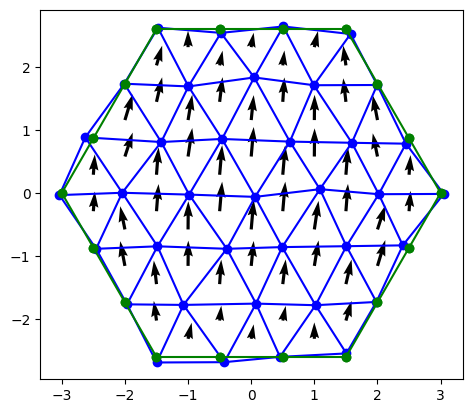

In [84]:
# Plot the vector field
plt.quiver(centroids[:,0], centroids[:,1], gradients[:, 0], gradients[:, 1])

# Set the aspect ratio to equal and show the plot
plt.gca().set_aspect('equal')

# Plot the triangular mesh
plt.triplot(triang, 'bo-')

for i in range(outer_edges.shape[0]):
    x_coords = trix[outer_edges[i, :]]
    y_coords = triy[outer_edges[i, :]]
    plt.plot(x_coords, y_coords, 'go-')

plt.show()


# Laplacian smoothing



In [90]:
def laplacian_smoothing(tri, trix, triy, iterations=1):
    for _ in range(iterations):
        new_trix = np.copy(trix)
        new_triy = np.copy(triy)

        for i in range(len(trix)):
            neighbors = np.where(np.any(tri == i, axis=0))[0]
            num_neighbors = len(neighbors)

            if num_neighbors > 0:
                average_x = np.mean(new_trix[neighbors])
                average_y = np.mean(new_triy[neighbors])

                new_trix[i] = average_x
                new_triy[i] = average_y

        trix = np.copy(new_trix)
        triy = np.copy(new_triy)

    return trix, triy

# Example usage
smoothed_trix, smoothed_triy = laplacian_smoothing(tri, trix, triy, iterations=1)


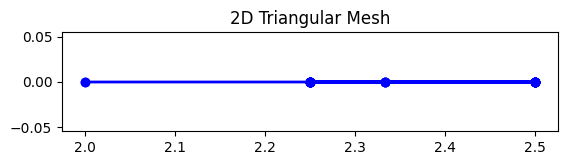

In [91]:
triang.x = smoothed_trix
triang.y = smoothed_triy

plotTriangularMesh(triang)
